# Import and Check OS

In [1]:
import re
import sys


import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import scipy.ndimage as nd
from scipy.stats import mode

import counting_functions as mcf

Using TensorFlow backend.


In [2]:
def change_contrast_brightness(image, alpha, beta):
    """
    https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html
    """
    new_image = np.zeros(image.shape, image.dtype)
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
    return new_image

def gamma_adjustment(img_original, gamma):
    """
    https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html
    """
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    res = cv2.LUT(img_original, lookUpTable)
    return res

In [4]:
if 'win32' in sys.platform:
    ex_filepath = 'F:\Colonies_Data\data\plate 2_24.png'
if 'darwin' in sys.platform:
    ex_filepath = "/Volumes/Samsung_T5/Colonies_Data/data/plate 2_24.png"

# Find the plate

## Find position and radius of the plate

In [5]:
# https://www.pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/
ex_filepath = "/Volumes/Samsung_T5/Segmentation_Data/VC0395_300mOsm_12.JPG"
IMG_SIZE = 1000

image = cv2.imread(ex_filepath)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
output = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, minDist=int(IMG_SIZE/3), dp=2, minRadius=int(IMG_SIZE/3), maxRadius=int(IMG_SIZE/2))
 
    
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circle_ = np.round(circles[0, :]).astype("int")
    print(circle_)
    # loop over the (x, y) coordinates and radius of the circles
    x, y, r = circle_[0]


[[525 461 470]]


## Extract the plate

In [ ]:
img = Image.open(ex_filepath).convert("RGB").resize((1000,1000))

npImage=np.array(img)
image = change_contrast_brightness(npImage, .8, 10)

# Create same size alpha layer with circle
alpha = Image.new('L', img.size,0)
draw = ImageDraw.Draw(alpha)
draw.pieslice([x-r, y-r, x+r, y+r],0,360,fill=255)

# Convert alpha Image to numpy array
npAlpha=np.array(alpha)

# Add alpha layer to RGB
npImage=np.dstack((image,npAlpha))

# Save with alpha
Image.fromarray(npImage).save('result.png')

# Find Small circles

In [ ]:
image = cv2.imread('result.png', cv2.IMREAD_UNCHANGED)
image2 = cv2.bitwise_not(image[:,:,:3])
output = image2.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, minDist=1, dp=2, minRadius=10, maxRadius=25, param2=37)
 
    
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circle_ = np.round(circles[0, :]).astype("int")
    print(circle_)
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circle_:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv2.circle(output, (x, y), r, (0, 255, 0), 4)
        cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
 
    # show the output image
#     cv2.imshow("output", np.hstack([image2, output]))
#     cv2.waitKey(0)

In [19]:
# def complete_fit(filepath:str, template:str, res_img1:str, res_img2:str, threshold:float=0.6):
#     """
#     Performs the complete process of:
#         1. Reading the image
#         2. Finding the instances/locations of the template subimage
#         3. Finding the unique/distinct boxes
#         4. Merging neighboring/overlapping boxes
#         5. Find the arrays of the boxes
#         6. Count number of colonies in each box
#         7. Adding up the total number of colonies in the image
#         8. Creating a final image containing the merged boxes and colony counts overlaid on the plate.
#     Inputs:
#         filepath: str; containing the file path to the image of the plate
#         template: str; containing the file path to the image of the template
#         res_img1: str; name to save the first resulting image
#         res_img2: str; name to save the second resulting image
#         threshold: float (in interval (0, 1]); threshold to set the template matching algorithm to. 
#             Higher means more strict matching, more likely to miss colonies. 
#             Lower means less strict matching, more likely to get false positives.
#     Outputs:
#         res_img1: first image, containing all matches to the template, including heavily overlapped matches
#         res_img2: second image, containing merged matches to the template and colony counts above the boxes
#     Returns: None
#     """
#     img = cv2.imread(filepath,0)
#     img_rgb = cv2.imread(filepath)
#     img_rgb2 = img_rgb.copy()
#     img_rgb3 = img_rgb.copy()
#     template_ = cv2.imread(template, 0)
#     w, h = template_.shape[::-1]
#     loc = create_init_image(img_rgb, template_, threshold=threshold, res_img=res_img1) 
#     matches = list(zip(*loc[::-1]))
#     matches = sorted(matches, key=lambda x:x[0])
#     unique_locs = find_unique_locs(matches, w, h)
#     merged_locs = find_merged_locs(unique_locs, w, h)
#     merged_locs = find_merged_locs(merged_locs, w, h)
#     colonies = extract_colonies(img_rgb3, merged_locs)
    
#     col_counts = []
#     tot_col_count = 0
#     for i in range(len(colonies)):
#         ex = colonies[i]
#         ex = prep_for_NN(ex)
#         preds = count_colonies_multi_rot(ex, model, [0, 1, 3])
#         pred = mode(preds, axis=None)[0][0]
#         tot_col_count += pred_num_col[pred]
#         col_counts.append(pred_num_col[pred])
    
#     create_final_image(img_rgb2, merged_locs, c_counts=col_counts, res_img=res_img2)
#     print(tot_col_count)
#     return colonies

In [31]:
# def create_init_image(img_rgb, template, threshold, res_img):
#     """
#     Creates the initial image, with all matches to the template outlined in red.
#     Inputs:
#         img_rgb: array of the image to highlight
#         template: template subimage to find in img_rgb
#         threshold: Threshold for the template matching algorithm
#         res_img1: filename to save the resulting image to.
#     Returns: None
#     """
#     img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
#     w, h = template.shape[::-1]
#     res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)
#     threshold = threshold
#     loc = np.where(res >= threshold)
#     for pt in zip(*loc[::-1]):
#         cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
#     cv2.imwrite(res_img, img_rgb)
#     return loc


# def find_unique_locs(matches, w, h):
#     """
#     Takes all matches to the template and returns a smaller set of boxes with additional space between them.
#     Inputs:
#         matches: a list of tuples containing a all matches to the template in the image.
#     Returns:
#         unique_locs: list of tuples containing less-overlapped boundary boxes
#     """
#     unique_locs = []
#     current_loc = matches[0]
#     curr_lim = matches[0]
#     for i, match in enumerate(matches):
#         if ((match[0] < current_loc[0] + w)
#             and(match[1] < current_loc[1] + h)
#             and(match[0] >= current_loc[0])
#                 and((match[1] >= current_loc[1] - h) and (match[1] <= current_loc[1] + h))):
#             current_lim = match
#         else:
#             unique_locs.append(
#                 (current_loc, (current_loc[0] + w, current_loc[1] + h)))
#             current_loc = match
#             unique_locs.append(
#                 (current_loc, (current_loc[0] + w, current_loc[1] + h)))
#             curr_lim = match
#     return unique_locs


# def find_merged_locs(unique_locs, w, h):
#     """
#     Merges overlapping boundary boxes of colonies.
#     Inputs: 
#         unique_locs: list of tuples containing data about the unique boundary boxes for colonies.
#     Returns:
#         merged_locs: list of tuples containing data about the boundary boxes for colonies, with 
#             nearby boxes merged with one another.
#     """
#     merged_locs = []
#     locs_to_skip = []
#     true_unique_locs = unique_locs.copy()
#     for location1 in true_unique_locs:
#         merge_count = 0
#         close_boxes = []
#         if location1 in locs_to_skip:
#             continue
#         for location2 in true_unique_locs:
#             if (location1 != location2) and is_close(location1, location2):
#                 close_boxes.append(location2)
#                 locs_to_skip.append(location2)
#                 merge_count += 1
#         if not close_boxes:
#             merged_locs.append(location1)
#         else:
#             farthest_box = find_farthest(location1, close_boxes)
#             merged_locs.append(merge_boxes(location1, farthest_box))
#     merged_locs = list(set(merged_locs))
#     return merged_locs


# def create_final_image(img, merged_locs, c_counts, res_img):
#     """
#     Creates the final image of the merged boundary boxes around colonies.
#     Inputs:
#         img: a numpy array of pixel intensities that make up the image.
#         merged_locs: set of merged boundary boxes for identified colonies.
#         c_counts: colony counts within each box, in the same order as merged_locs
#         res_img: file name to save resulting image to.
#     Returns: None
#     """
#     for i, ul in enumerate(merged_locs):
#         upper_left, lower_right = ul[0], ul[1]
#         cv2.rectangle(img, upper_left, lower_right, (0, 255, 0), 4)
#         cv2.putText(img, 
#                     str(c_counts[i]), 
#                     upper_left,
#                     fontFace=4,
#                     fontScale=3,
#                     color=[0, 0, 0])
#     cv2.imwrite(res_img, img)


# def extract_colonies(img, boxes):
#     """
#     Gives arrays (to be converted to images) of all found colonies on the dish.
#     Inputs:
#         img:base image containing colonies.
#         boxes: locations of boxes containing colonies.
#     Returns:
#         colonies: arrays (to be converted to images) containing supposed colonies.
#     """
#     colonies = []
#     for box in boxes:
#         y1 = box[0][0]
#         x1 = box[0][1]
#         y2 = box[1][0]
#         x2 = box[1][1]
#         sub_image = img[x1:x2+1, y1:y2+1,:]
#         colonies.append(sub_image)
#     return colonies

# def is_close(loc1, loc2, w=100, h=100):
#     """
#     Determines if 2 locations are close to one another.
#     Inputs:
#         loc1: first location
#         loc2: second location
#         w: width of box determining closeness
#         h: height of box determining closeness
#     Returns:
#         bool; Whether or not loc1 and loc2 are close.
#     """
#     loc1_f = np.array(loc1[1])
#     loc2_f = np.array(loc2[1])
#     diag_of_rect = np.sqrt(w ** 2 + h ** 2)
#     if np.linalg.norm(loc1_f - loc2_f, 2) <  diag_of_rect:# max(w, h):
#         return True
#     else:
#         return False
    
# def merge_boxes(box_1, box_2):
#     """
#     Merges 2 overlapping/close boxes.
#     Inputs:
#         box_1:
#         box_2:
#     Returns:
#         new_box:
#     """
#     new_box_x1 = min(box_1[0][0], box_2[0][0])
#     new_box_x2 = max(box_1[1][0], box_2[1][0])
#     new_box_y1 = min(box_1[0][1], box_2[0][1])
#     new_box_y2 = max(box_1[1][1], box_2[1][1])
#     new_box = ((new_box_x1, new_box_y1), (new_box_x2, new_box_y2))
#     return new_box


# def overlap(box_1, box_2):
#     """
#     Determines if two boxes are overlapping
#     Inputs: 
#         box_1:
#         box_2:
#     Returns:
#         bool; whether the two boxes are overlapping
#     """
#     x11 = box_1[0][0]
#     y11 = box_1[0][1]
#     x12 = box_1[1][0]
#     y12 = box_1[1][1]
#     x21 = box_2[0][0]
#     y21 = box_2[0][1]
#     x22 = box_2[1][0]
#     y22 = box_2[1][1]
#     if ((((x21 <= x12) and (x22 >= x12) and (y21 >= y12) and (y22 <= y12))) 
#         or ((x21 >= x12) and (x22 <= x12) and (y21 <= y12) and (y22 >= y12))
#         or ((x11 >=x21) and (x11 <= x22) and (y11<= y21) and (y12 >= y21))
#         or ((x11 >= x21) and (x11 <= x22) and (y11 >= y21) and (y11 <= y22))):
#             return True
#     else:
#         return False
    
    
# def find_farthest(box_1, other_boxes):
#     """
#     Finds the box farthest from the given box.
#     Inputs:
#         box_1: Lower Left/Top Right corners of a box
#         other_boxes: Lower left/Top right corners of the nearby boxes
#     Returns:
#         Coordinates for the box that if farthest away
#     """
#     dists = []
#     for ob in other_boxes:
#         box_1_array = np.array(box_1[0])
#         ob_array = np.array(ob[0])
#         dists.append(np.linalg.norm(box_1_array - ob_array, 2))
#     farthest_idx = dists.index(max(dists))
#     return other_boxes[farthest_idx]

# def find_max_boxes(locs, w, h):
#     """
#     Deprecated, see merge_boxes.
#     """
#     loc_1 = locs[0]
#     loc_2 = locs[1]
#     upper_left = (min(loc_1[0], loc_2[0]), max(loc_1[1], loc_2[1]))
#     lower_right = (max(loc_1[0], loc_2[0]) , max(loc_1[1], loc_2[1]) - h)
#     return (upper_left, lower_right)


## Feed into NN

In [2]:
model = keras.models.load_model('balanced_gray_classes.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


0.98488545
0.6460014
0.0824715
0.97032803
0.9998902
0.99921954
0.4963332
0.97000164
0.99840504
0.9997414
0.99958724
0.99998915
0.9646579
0.95970154
0.6787831
0.9993425
0.9983411
0.9942405
0.9987739
0.466043
0.93687445
0.96514523
0.7468167
0.98607963


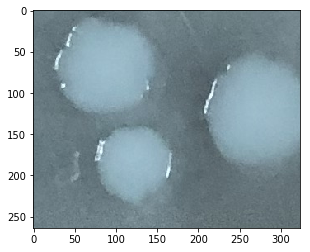

In [39]:
for i in range(len(mc3)):
    ex = mc3[i]
    ex = cv2.resize(ex, dsize=(128,128))
    ex = ex.reshape([-1, 128, 128, 1])
    print(model.predict(ex)[0])

In [5]:
# def rgb2gray(rgb):
#     """
#     Converts color image to grayscale
#     Inputs:
#         rgb: np.ndarray; RGB image in the form of an array
#     Returns:
#         grayscale version of rgb.
#     """
#     return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


# def prep_for_NN(img:np.ndarray, 
#                 shape:tuple=(128, 128),
#                 gray:bool=True):
#     """
#     Converts to grayscale(or not) and scales image to given size to be able to be fed to the neural network.
#     Inputs:
#         img: ndarray; image to prepare for neural network
#         shape: tuple; desired shape to be fed to the neural network
#         gray: bool; Whether or not to convert to grayscale
#     Returns:
#         ex: ndarray; array containing the grayscaled/scaled image.
#     """
#     ex = rgb2gray(img)
#     ex = cv2.resize(ex, dsize=(128,128))
#     ex = ex.reshape([-1, 128, 128, 1])
#     return ex


# def find_num_cols_rot(img:np.ndarray,
#                       model:keras.engine.training.Model,
#                       k:int=0):
#     """
#     Finds the prediction of number of colonies for a given rotation of a root image.
#     Inputs:
#         img: np.ndarray; subimage to rotate and find colonies in
#         model: model to identify colony counts in each subimage
#         k: int; number of 90-degree rotations to perform before evaluating with the model. 
#     """
#     ex = np.rot90(img, k=k, axes=(1, 2))
#     max_pred = np.max(model.predict(ex)[0])
#     prediction = np.where(model.predict(ex)[0] == max_pred)[0][0]
#     return prediction
    
    
# def count_colonies_multi_rot(img:np.ndarray,
#                              model:keras.engine.training.Model,
#                              k:list=[0]):
#     """
#     Estimates number of colonies in img. Does multiple rotations of image, classifies each of them,
#     and has the rotations vote on classification.
#     Inputs:
#         img: Image to count the colonies on.
#         model: A classification model with a .predict function 
#         k: a list containing integers of the number of 90-degree turns to rotate and evaluate an image
#     Returns: Array of votes from each of the rotations.
#     """
#     num_cols = []
#     for rots in k:
#         pred = find_num_cols_rot(img, model, rots)
#         num_cols.append(pred)
#     num_array = np.array(num_cols)
#     return num_array


In [114]:
col_count = 0
for i in range(len(mc3)):
    ex = mc3[i]
    ex = mcf.prep_for_NN(ex)
    preds = mcf.count_colonies_multi_rot(ex, model, [0, 1, 3])
    pred = mode(preds, axis=None)[0][0]
    col_count += pred_num_col[pred]
col_count

35

### Testing

In [3]:
mc3 = mcf.complete_fit("/Volumes/Samsung_T5/Segmentation_Data/Sukharev_Lab_Data/plates/MJF465_400mOsm_37(1).JPG",
                   "/Volumes/Samsung_T5/Segmentation_Data/Sukharev_Lab_Data/colonies/MJF465_400mOsm_37(1)_colony2.jpg",
                   "data/res_37(1).png",
                   "data/res_37(1)_count.png",
                   model_=model,
                   threshold=0.50)

35


In [6]:
mc4 = mcf.complete_fit("/Volumes/Samsung_T5/Segmentation_Data/Sukharev_Lab_Data/plates/MJF465_600mOsm_40.JPG",
                   "/Volumes/Samsung_T5/Segmentation_Data/Sukharev_Lab_Data/colonies/MJF465_600mOsm_40_colony.jpg",
                   "data/res_40.png",
                   "data/res_40_count.png",
                   model_=model,
                  threshold=0.5)

37


In [7]:
mc5 = mcf.complete_fit("/Volumes/Samsung_T5/Segmentation_Data/Sukharev_Lab_Data/plates/VC0395_350mOsm_22.jpg",
                   "/Volumes/Samsung_T5/Segmentation_Data/Sukharev_Lab_Data/colonies/VC0395_350mOsm_22_colony.jpg",
                   "data/res_22.png",
                   "data/res_22_count.png",
                   model_=model,
                   threshold=0.45)

22


In [13]:
for mc in mc5:
    ex = mcf.prep_for_NN(mc)
    print(mcf.find_num_cols_rot(ex, model))
#     plt.figure()
#     plt.imshow(mc)

In [27]:
mc5 = mcf.complete_fit("/Volumes/Samsung_T5/Segmentation_Data/Sukharev_Lab_Data/plates/VC0395_350mOsm_22.jpg",
                   "/Volumes/Samsung_T5/Segmentation_Data/Sukharev_Lab_Data/colonies/VC0395_350mOsm_22_colony.jpg",
                   "data/res_22.png",
                   "data/res_22_count.png",
                   model_=model,
                   threshold=0.45)

22


## On Windows

2
2
2
0
2
2
0
0
2
2
2
2
2
0
2
0
2
2
2
2
0
2
0
2


C:\Users\acsch\Anaconda3\envs\Tensorflow-GPU\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


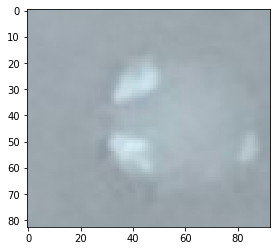

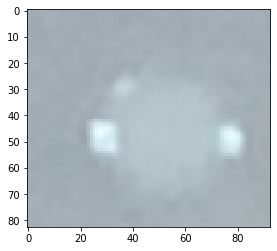

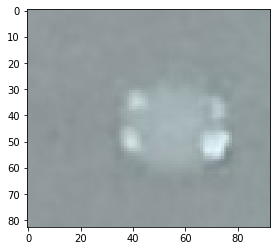

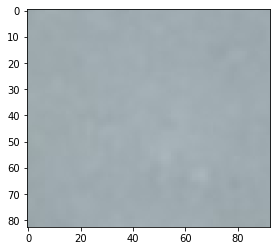

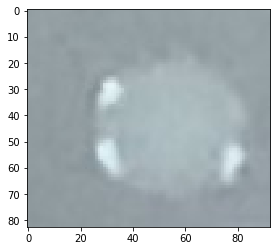

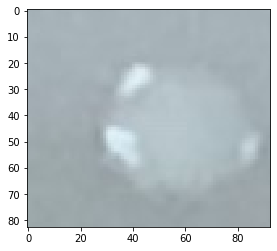

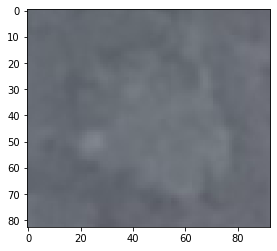

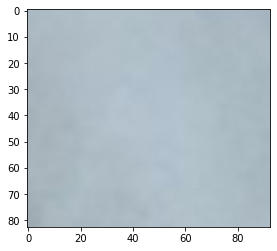

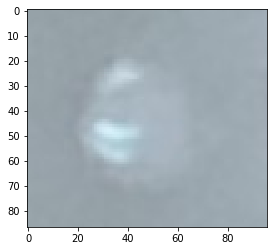

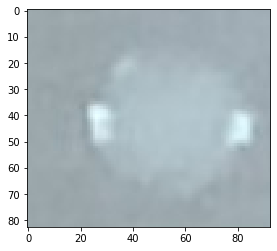

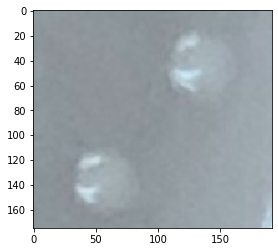

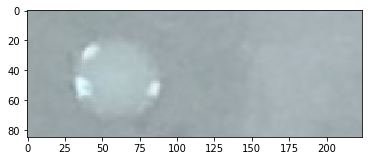

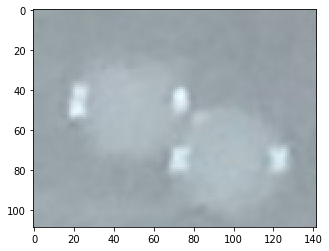

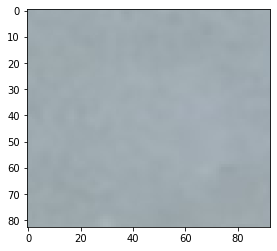

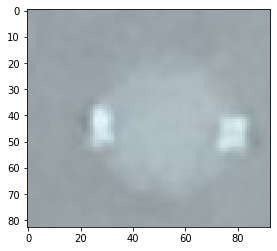

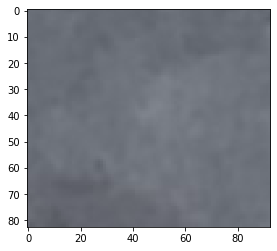

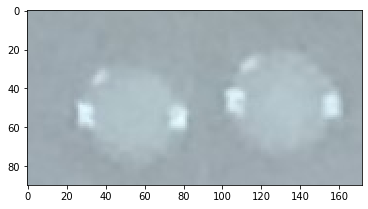

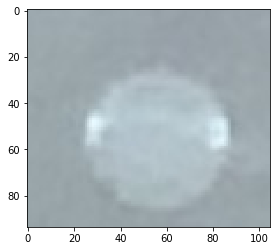

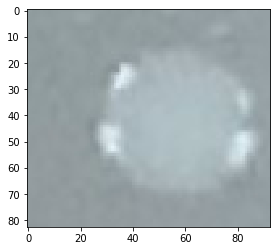

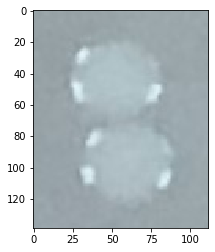

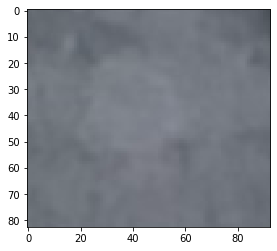

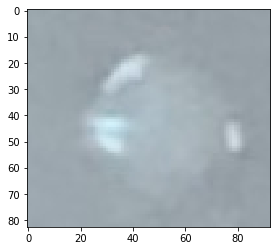

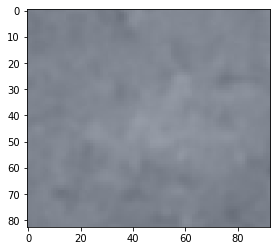

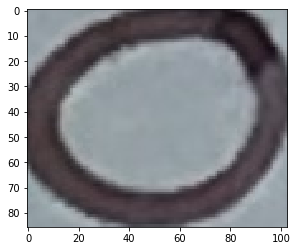

In [14]:
for mc in mc5:
    ex = mcf.prep_for_NN(mc)
    plt.figure()
    print(mcf.find_num_cols_rot(ex, model))
    plt.imshow(mc)

In [ ]:
for colony in mc3:
    plt.figure()
    plt.imshow(colony)